# Project : Machine Learning Based Predictive Maintenance

# Part 2: Modeling

- In this notebook, I want to illustrate how to train a Random Forest model with the "Aircraft Predictive Maintenance" dataset using the Snowpark ML Model API. 
- The goal is also to deploy the model in the Snowflake framework via Model Registry or as a UDF, in order to perform future inference.

# 1. Load packages and dependencies

In [136]:
# data science libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

# misc
import json
import joblib
import cachetools

# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import udf
import snowflake.snowpark.functions as F
# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

# Snowpark ML
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import model_registry
from snowflake.ml._internal.utils import identifier

# Scikit-learn functions
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [137]:
# Jupyter Notebook Options
plt.style.use('ggplot')
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
%matplotlib inline
warnings.filterwarnings('ignore')

# 2. Establish the secure connection to Snowflake

In [138]:
# Make a Snowpark Connection by editing the connection.json before creating the session object below
# You need to replace my credential "AD_XXXXXXXXXXX" by yours and load "TRAIN_TABLE" and "TEST_TABLE" to run this notebook. 
# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : ADDATABOOST
Role                        : "ACCOUNTADMIN"
Database                    : "PREV_MAINT_DB"
Schema                      : "PREV_MAINT_SCHEMA"
Warehouse                   : "PREV_MAINT_WH"
Snowflake version           : 8.10.1
Snowpark for Python version : 1.10.0


# 3. Load the data & preprocessing pipeline

## 3.1. Data Loading

In [139]:
# Load in the train data
# PM_TRAIN_TABLE = 'TRAIN_TABLE' 
# input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{PM_TRAIN_TABLE}"
# df_train = session.table(input_tbl)

In [140]:
# Load in the train data
# PM_TEST_TABLE = 'TEST_TABLE' 
# input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{PM_TEST_TABLE}"
# df_test = session.table(input_tbl)

In [141]:
# features = ["SETTING1", "SETTING2", "SETTING3", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12", 
#             "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

In [142]:
# FEATURES = ["SETTING1", "SETTING2", "SETTING3", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12", 
#             "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21", "AV1", "AV2", "AV3", "AV4", "AV5", "AV6", "AV7", 
#             "AV8", "AV9", "AV10", "AV11", "AV12", "AV13", "AV14", "AV15", "AV16", "AV17", "AV18", "AV19", "AV20", "AV21", 
#             "SD1", "SD2", "SD3", "SD4", "SD5", "SD6", "SD7", "SD8", "SD9", "SD10", "SD11", "SD12", "SD13", "SD14", "SD15", 
#             "SD16", "SD17", "SD18", "SD19", "SD20", "SD21"]

## 3.2. Features transformation

In [143]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [144]:
features = ["setting1", "setting2", "setting3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11", "s12", 
            "s13", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21"]

In [145]:
# Normalize the CARAT column
# snowml_mms = snowml.StandardScaler(input_cols=features, output_cols=features)
# df_train = snowml_mms.fit(df_train).transform(df_train)

In [146]:
Target = 'label_mcc'
# X/y Split
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train[Target]
y_test = df_test[Target]

In [147]:
# df_train = df_train[features]
# df_test = df_test[features]

In [148]:
# Standardscaler instanciation 
scaler = StandardScaler()
# Standardization of data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [149]:
# Labeling of the target
# lb = LabelBinarizer()
# y_train = lb.fit_transform(y_train)
# y_test = lb.transform(y_test)
# snowml_le = snowml.LabelEncoder(input_cols=Target, output_cols=Target)
# y_train = snowml_le.fit(y_train).transform(y_train)
# y_test = snowml_le.fit(y_test).transform(y_test)

In [150]:
# Stratifier for GridSearchCV optimization
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=21)

In [151]:
# Build the pipeline
# preprocessing_pipeline = Pipeline(
#     steps=[
#             (
#                 "OE",
#                 snowml.OrdinalEncoder(
#                     input_cols=CATEGORICAL_COLUMNS,
#                     output_cols=CATEGORICAL_COLUMNS_OE,
#                     categories=categories,
#                 )
#             ),
#             (
#                 "MMS",
#                 snowml.StandardScaler(
#                     input_cols=features,
#                     output_cols=features,
#                 )
#             )
#     ]
# )

# PIPELINE_FILE = 'preprocessing_pipeline.joblib'
# joblib.dump(preprocessing_pipeline, PIPELINE_FILE) # We are just pickling it locally first

# X_train = preprocessing_pipeline.fit(X_train).transform(X_train)
# X_test = preprocessing_pipeline.fit(X_test).transform(X_test)
# X_train.show()

# 3. Modeling

## 3.1 Random Forest

In [152]:
model_name = 'Random Forest'
clf = RandomForestClassifier(n_estimators=50, random_state=123)
params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
score = 'roc_auc'

In [153]:
grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=ss, scoring=score, n_jobs=-1)

In [154]:
# Define the XGBRegressor
# regressor = XGBRegressor(
#     input_cols=features,
#     output_cols='PREDICTED_PRICE'
# )

# # Train
# regressor.fit(X_train)

# # Predict
# result = regressor.predict(X_test)

In [155]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=21, test_size=0.25, train_size=None),
             estimator=RandomForestClassifier(n_estimators=50,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8]},
             scoring='roc_auc')

In [156]:
y_pred = grid_search.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [157]:
# y_score[0][1]

In [158]:
y_score = grid_search.predict_proba(X_test)
# y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
# y_score = np.concatenate(y_score, axis=1)
y_score

array([[9.92969963e-01, 6.86211169e-03, 1.67924931e-04],
       [9.92969963e-01, 6.86211169e-03, 1.67924931e-04],
       [7.73885385e-01, 1.86915360e-01, 3.91992554e-02],
       [9.25696229e-01, 6.56210466e-02, 8.68272391e-03],
       [9.30666410e-01, 6.23038818e-02, 7.02970813e-03],
       [9.91875925e-01, 7.85272582e-03, 2.71349295e-04],
       [9.92969963e-01, 6.86211169e-03, 1.67924931e-04],
       [8.85848842e-01, 1.01949530e-01, 1.22016279e-02],
       [9.88522452e-01, 1.11108430e-02, 3.66705303e-04],
       [9.91680187e-01, 8.03874650e-03, 2.81066794e-04],
       [9.37723878e-01, 5.64379538e-02, 5.83816820e-03],
       [9.89743707e-01, 9.61760998e-03, 6.38682839e-04],
       [9.91545257e-01, 8.24383485e-03, 2.10907918e-04],
       [9.52566456e-01, 4.44342612e-02, 2.99928272e-03],
       [9.92969963e-01, 6.86211169e-03, 1.67924931e-04],
       [9.91680187e-01, 8.03874650e-03, 2.81066794e-04],
       [9.80120960e-01, 1.88037317e-02, 1.07530786e-03],
       [8.87666530e-01, 9.65184

In [159]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=123)

In [160]:
dict_results = {'Model_name':model_name,
           'Accuracy' : metrics.accuracy_score(y_test, y_pred),
           'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
           'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
           'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
           'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
           'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
           'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
           'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro', multi_class='ovr'), # , multi_class='ovr'
           'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro', multi_class='ovr')}

In [161]:
df_resultats = pd.DataFrame(dict_results, index=[0])
df_resultats

,Model_name,Accuracy,macro F1,micro F1,macro Precision,micro Precision,macro Recall,micro Recall,macro ROC AUC,micro ROC AUC
0,Random Forest,0.88,0.73913,0.88,0.927061,0.88,0.733333,0.88,0.958332,0.97405


In [162]:
def roc_auc_curve(y_test, y_score, model):
    
    n_classes = y_train.shape[1]
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    
    colors = cycle(['red', 'green', 'blue'])
        
    plt.figure(figsize=(8,8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right", fontsize='small')
    plt.show()

In [163]:
roc_auc_curve(y_test, y_score, "RF")

IndexError: tuple index out of range

In [164]:
def repalcement(l):
    l2 = []
    for i in range(len(l)):
        if l[i] == 0:
            l2.append('Pas de risque')
        elif l[i] == 1:
            l2.append('Risque faible')
        elif l[i] == 2:
            l2.append('Risque fort')
    return l2

In [165]:
y_test2 = repalcement(y_test)
y_pred2 = repalcement(y_pred)

In [168]:
cm = metrics.confusion_matrix(y_test2, y_pred2)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test2), index = np.unique(y_test2))

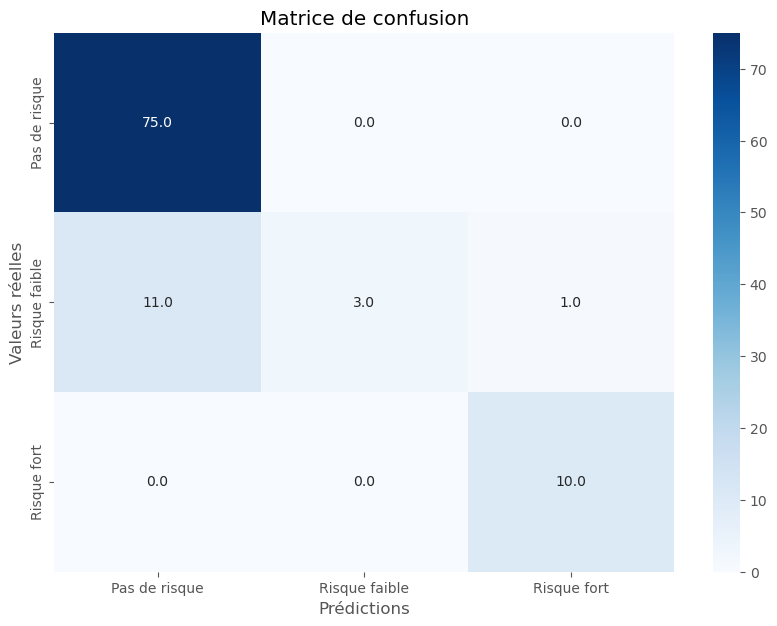

In [169]:
# Création de la heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.1f')
plt.title('Matrice de confusion')
plt.ylabel('Valeurs réelles')
plt.xlabel('Prédictions')
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)
# features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [134]:
# Enregistrement du modèle
import pickle
best_model = grid_search.best_estimator_
# Enregistrement du modèle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [136]:
from joblib import dump

# Obtention du meilleur modèle à partir de la recherche sur grille
best_model = grid_search.best_estimator_

# Enregistrement du modèle avec joblib
dump(best_model, 'best_model.joblib')

['best_model.joblib']

In [34]:
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [42]:
sample = X_train[-1,:].reshape(1, -1)

In [50]:
prediction = loaded_model.predict_proba(sample)
prediction

[array([[9.99189172e-01, 8.10828201e-04]]),
 array([[0.97339635, 0.02660365]]),
 array([[0.02741448, 0.97258552]])]

In [54]:
prediction[1][0]

array([0.97339635, 0.02660365])

# 4. Explainability

## 4.1 SHAP Value Analysis

In [70]:
import shap

In [72]:
explainer = shap.TreeExplainer(grid_search.best_estimator_)

In [74]:
X_test = df_test[features]
choosen_instance = X_test.loc[[1]]

In [75]:
shap_values = explainer.shap_values(choosen_instance)

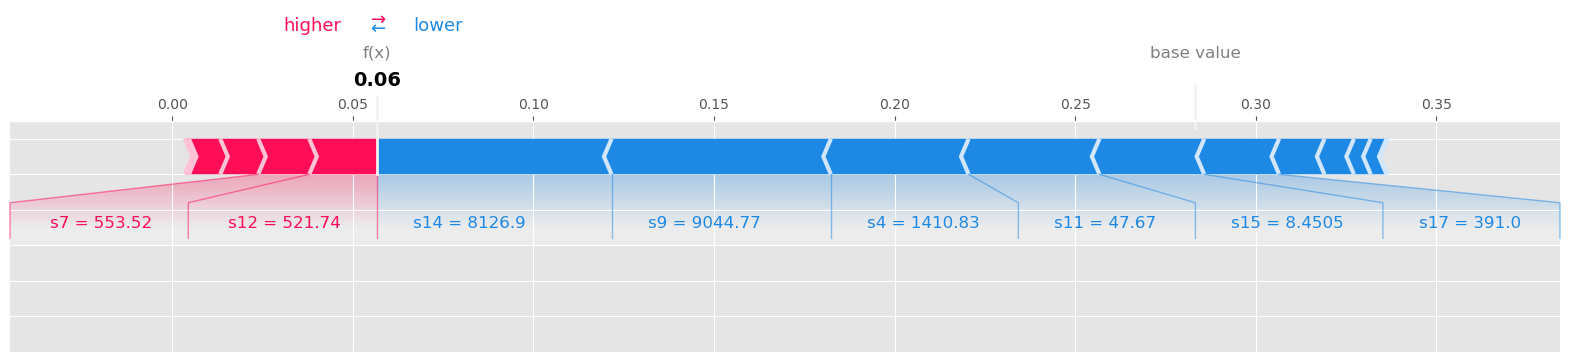

In [82]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, matplotlib=True)

In [56]:
class_names = ['0', '1', '2']

In [57]:
X = np.concatenate((X_train, X_test), axis=0)

In [58]:
# X = pd.concat([df_train, df_test], axis=0)

In [59]:
X.shape

(20731, 24)

In [64]:
X = X_train

In [69]:
X

array([[-0.31597968, -1.3729532 ,  0.        , ...,  0.        ,
         1.34849274,  1.19442705],
       [ 0.87272193, -1.03172035,  0.        , ...,  0.        ,
         1.01652793,  1.23692196],
       [-1.96187421,  1.01567674,  0.        , ...,  0.        ,
         0.73989059,  0.50342281],
       ...,
       [ 0.18693254, -0.00802181,  0.        , ...,  0.        ,
        -2.08181033, -3.29248147],
       [-0.49885685,  1.01567674,  0.        , ...,  0.        ,
        -2.91172236, -2.08507166],
       [-1.458962  , -1.71418605,  0.        , ...,  0.        ,
        -2.46910261, -2.19408035]])

In [68]:
X[:,-1]

array([ 1.19442705,  1.23692196,  0.50342281, ..., -3.29248147,
       -2.08507166, -2.19408035])

In [31]:
# compute SHAP values
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X)

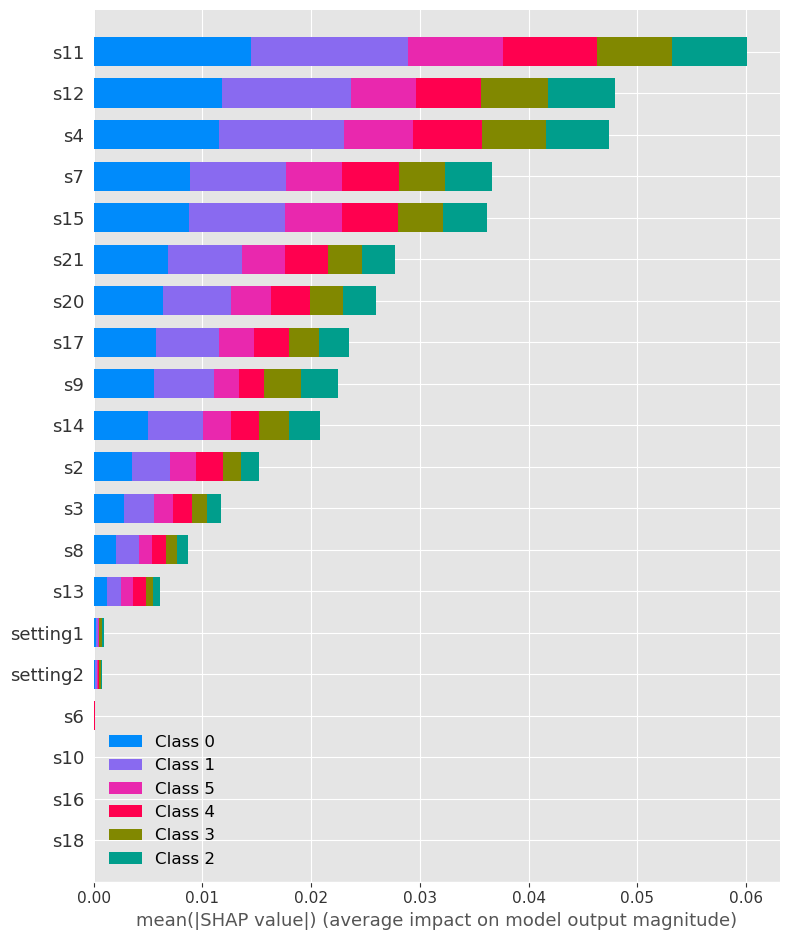

In [32]:
shap.summary_plot(shap_values, X, plot_type="bar", feature_names = features)

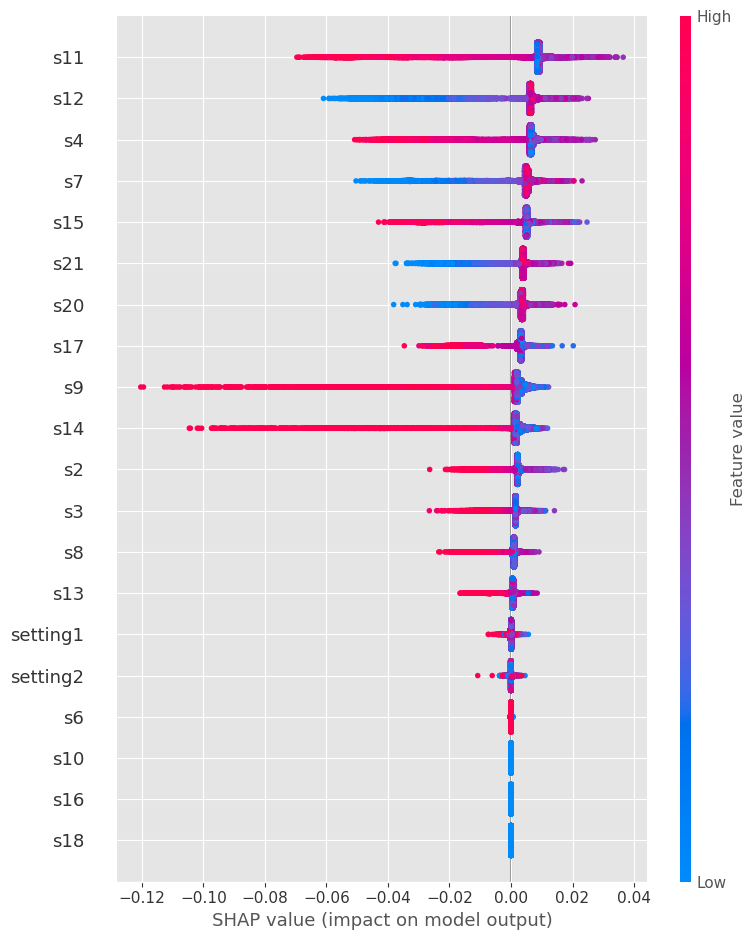

In [33]:
shap.summary_plot(shap_values[1], X, feature_names = features)

In [175]:
df = pd.read_csv('train.csv')
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11',
        's12','s13','s14','s15','s16','s17','s18','s19','s20','s21','label_mcc']
df = df[features]
columns_title = ["setting_1", "setting_2", "setting_3", "(Fan inlet temperature) (◦R)", "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)", "(LPT outlet temperature) (◦R)", "(Fan inlet Pressure) (psia)", "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)", "(Physical fan speed) (rpm)", "(Physical core speed) (rpm)", "(Engine pressure ratio(P50/P2)", 
    "(HPC outlet Static pressure) (psia)", "(Ratio of fuel flow to Ps30) (pps/psia)", "(Corrected fan speed) (rpm)", "(Corrected core speed) (rpm)",
    "(Bypass Ratio) ", "(Burner fuel-air ratio)", "(Bleed Enthalpy)", "(Required fan speed)", "(Required fan conversion speed)", "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)", "Label"]
columns_title_wt = ["setting_1", "setting_2", "setting_3", "(Fan inlet temperature) (◦R)", "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)", "(LPT outlet temperature) (◦R)", "(Fan inlet Pressure) (psia)", "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)", "(Physical fan speed) (rpm)", "(Physical core speed) (rpm)", "(Engine pressure ratio(P50/P2)", 
    "(HPC outlet Static pressure) (psia)", "(Ratio of fuel flow to Ps30) (pps/psia)", "(Corrected fan speed) (rpm)", "(Corrected core speed) (rpm)",
    "(Bypass Ratio) ", "(Burner fuel-air ratio)", "(Bleed Enthalpy)", "(Required fan speed)", "(Required fan conversion speed)", "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)"]
df.columns = columns_title

In [176]:
sample = pd.concat([df[df['Label'] == 0].sample(20), df[df['Label'] == 1].sample(20), df[df['Label'] == 2].sample(20)], axis=0)
sample = sample.sample(1)
sample = sample.drop('Label', axis=1)

In [177]:
target = df['Label']
df = df.drop('Label', axis=1)
X = pd.concat([df[columns_title_wt], sample], axis=0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [178]:
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
sample_to_predict = X_scaled[-1,:]

In [179]:
sample_to_predict

array([ 7.35536580e-01, -3.49245161e-01,  0.00000000e+00,  0.00000000e+00,
        1.38118128e-01, -3.47913935e-01,  4.92877124e-01, -1.77635684e-15,
        1.41679826e-01, -1.03682672e+00,  1.45583368e+00, -3.92290707e-01,
       -2.22044605e-16,  8.19313439e-01, -1.15712616e+00,  1.16582467e+00,
       -4.83465339e-01,  1.22257594e+00, -1.38777878e-17,  1.80087388e+00,
        0.00000000e+00,  0.00000000e+00, -1.03053692e+00, -2.30827778e+00])

In [222]:
columns = list(df.columns)
columns

['setting_1',
 'setting_2',
 'setting_3',
 '(Fan inlet temperature) (◦R)',
 '(LPC outlet temperature) (◦R)',
 '(HPC outlet temperature) (◦R)',
 '(LPT outlet temperature) (◦R)',
 '(Fan inlet Pressure) (psia)',
 '(bypass-duct pressure) (psia)',
 '(HPC outlet pressure) (psia)',
 '(Physical fan speed) (rpm)',
 '(Physical core speed) (rpm)',
 '(Engine pressure ratio(P50/P2)',
 '(HPC outlet Static pressure) (psia)',
 '(Ratio of fuel flow to Ps30) (pps/psia)',
 '(Corrected fan speed) (rpm)',
 '(Corrected core speed) (rpm)',
 '(Bypass Ratio) ',
 '(Burner fuel-air ratio)',
 '(Bleed Enthalpy)',
 '(Required fan speed)',
 '(Required fan conversion speed)',
 '(High-pressure turbines Cool air flow)',
 '(Low-pressure turbines Cool air flow)']

In [187]:
prediction = loaded_model.predict_proba(sample_to_predict.reshape(1, -1))
prediction_class = loaded_model.predict(sample_to_predict.reshape(1, -1))

In [181]:
prediction

array([[0.61345873, 0.29168138, 0.09485989]])

In [189]:
prediction_class[0]

0

In [225]:
import shap

In [226]:
explainer = shap.TreeExplainer(loaded_model)
choosen_instance = sample_to_predict.reshape(1, -1)
shap_values = explainer.shap_values(choosen_instance)

In [244]:
shap.initjs()
shap.force_plot(explainer.expected_value[prediction_class[0]], shap_values[prediction_class[0]], choosen_instance, feature_names=columns)

In [240]:
shap_values[0]

array([[ 2.59186554e-05,  4.15318502e-07,  0.00000000e+00,
         0.00000000e+00,  1.32119383e-02,  7.84699958e-03,
         3.55990405e-02,  0.00000000e+00, -2.08413289e-04,
        -5.78889352e-02, -1.21540123e-02,  1.08821884e-02,
         0.00000000e+00,  3.94264475e-02, -6.56789781e-02,
        -5.87285670e-04,  5.99287156e-03, -6.95746407e-02,
         0.00000000e+00, -5.56251400e-02,  0.00000000e+00,
         0.00000000e+00, -6.92580865e-03, -8.06565487e-02]])

In [215]:
explainer = shap.Explainer(loaded_model, choosen_instance)
shap_values2 = explainer(choosen_instance)

In [216]:
shap.plots.waterfall(shap_values2.data[0])

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [220]:
shap_values2

.values =
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

.base_values =
array([[0.61345873, 0.29168138, 0.09485989]])

.data =
array([[ 7.35536580e-01, -3.49245161e-01,  0.00000000e+00,
         0.00000000e+00,  1.38118128e-01, -3.47913935e-01,
         4.92877124e-01, -1.77635684e-15,  1.41679826e-01,
        -1.03682672e+00,  1.45583368e+00, -3.92290707e-01,
        -2.22044605e-16,  8.19313439e-01, -1.15712616e+00,
         1.16582467e+00, -4.83465339e-01,  1.22257594e+00,
        -1.38777878e-17,  1.8008738

In [212]:
import xgboost

import shap

# train XGBoost model
X, y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 32467/32561 [00:39<00:00]        

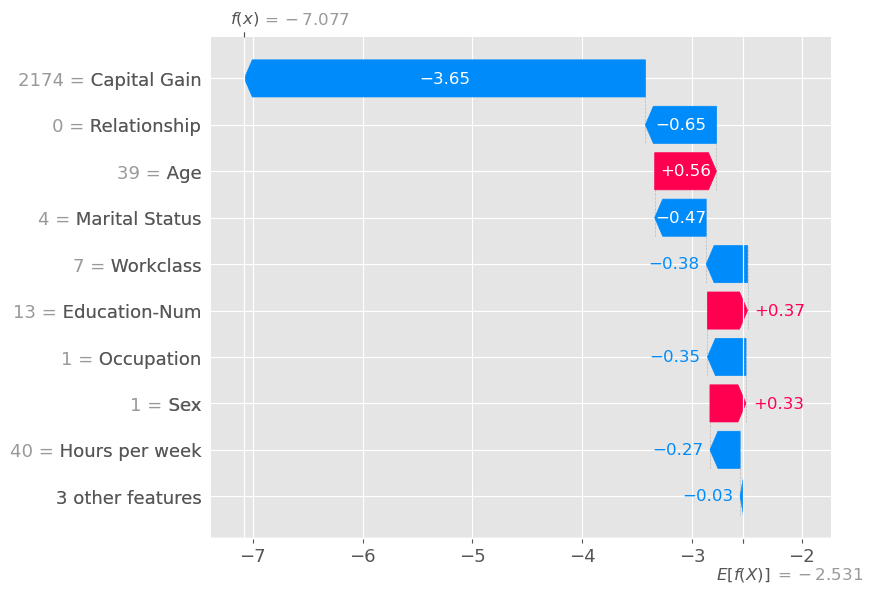

In [213]:
shap.plots.waterfall(shap_values[0])

In [214]:
shap_values

.values =
array([[ 0.56290748, -0.37707573,  0.36556202, ..., -0.08319319,
        -0.27460556,  0.03407126],
       [ 0.8329324 , -0.33895554,  0.74247157, ..., -0.10564631,
        -1.56332388,  0.048605  ],
       [ 0.4049682 , -0.00817018, -0.4744835 , ..., -0.0832847 ,
        -0.13448898,  0.00816027],
       ...,
       [ 1.09473065,  0.02295769, -0.32467409, ..., -0.08354948,
        -0.16966392,  0.06724443],
       [-1.39847998,  0.00947645, -0.17965936, ..., -0.10226174,
        -1.33205647, -0.01489729],
       [ 0.77162149,  0.05728497, -0.25236696, ..., -0.03281867,
         0.02203016,  0.04181268]])

.base_values =
array([-2.5312646, -2.5312646, -2.5312646, ..., -2.5312646, -2.5312646,
       -2.5312646])

.data =
array([[39.,  7., 13., ...,  0., 40., 39.],
       [50.,  6., 13., ...,  0., 13., 39.],
       [38.,  4.,  9., ...,  0., 40., 39.],
       ...,
       [58.,  4.,  9., ...,  0., 40., 39.],
       [22.,  4.,  9., ...,  0., 20., 39.],
       [52.,  5.,  9., ..., 